This is where base BERT lives :)

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)


model.eval()  # eval mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # (batch, seq_len, hidden)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    summed = (token_embeddings * input_mask_expanded).sum(dim=1)
    counts = input_mask_expanded.sum(dim=1)
    return summed / counts

In [6]:
@torch.no_grad()
def encode_texts(texts, batch_size=16, device="cpu", normalize=True):
    """
    texts: list of strings
    returns: numpy array (n_texts, hidden_dim)
    """
    model.to(device)
    all_embs = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        outputs = model(**encoded)
        sentence_embeddings = mean_pooling(outputs, encoded["attention_mask"])  # (B, hidden)
        if normalize:
            sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
        all_embs.append(sentence_embeddings.cpu().numpy())

    return np.vstack(all_embs)

In [ ]:

df = pd.read_csv("../data/cleaned_courses.csv")

print(df.columns)

texts = df["TextForBERT"].astype(str).tolist()
len(texts), texts[0][:200]

Index(['Faculty', 'Code', 'Title', 'Description', 'Components',
       'Prerequisites', 'TextForBERT'],
      dtype='object')


(527,
 'electronics i. physics of semiconductors. diodes: operation, models. and application circuits. bipolar junction transistors - operation and characteristics. dc and ac circuit models. basic single-stag')

In [ ]:
embeddings = encode_texts(texts, batch_size=16)
print(embeddings.shape)  # (num_courses, 768)

(527, 768)


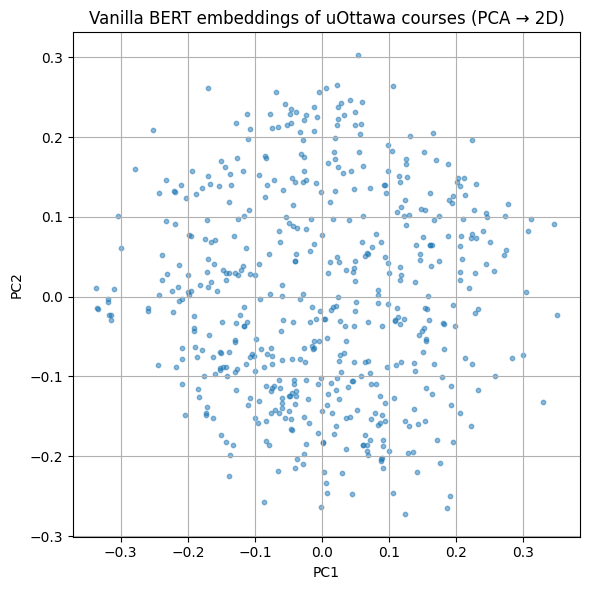

In [10]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(6, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], alpha=0.5, s=10)
plt.title("Vanilla BERT embeddings of uOttawa courses (PCA → 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

Mean cosine similarity: 0.8286793
Std cosine similarity: 0.046401184


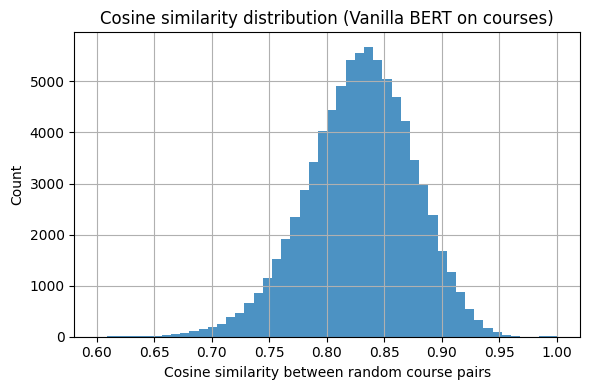

In [ ]:

n = min(400, embeddings.shape[0])
sub_embs = embeddings[:n]

sim_matrix = cosine_similarity(sub_embs, sub_embs)

#Take only upper triangle (without diagonal) to avoid duplicates/self-similarity
i_upper = np.triu_indices(n, k=1)
sims = sim_matrix[i_upper]

print("Mean cosine similarity:", sims.mean())
print("Std cosine similarity:", sims.std())

plt.figure(figsize=(6, 4))
plt.hist(sims, bins=50, alpha=0.8)
plt.title("Cosine similarity distribution (Vanilla BERT on courses)")
plt.xlabel("Cosine similarity between random course pairs")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()